In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.optimize import minimize

df_ajustado = pd.read_csv("Datos/Transformados/limpio.csv", index_col=0)
df_ajustado.index = pd.to_datetime(df_ajustado.index)
rent_diarias = df_ajustado.pct_change()

1º OPCIÓN: Métricas

In [3]:
import itertools
import numpy as np
import pandas as pd

def generar_carteras(df_precios, risk_free_rate=0.0):

    returns = df_precios.pct_change().dropna()
    cov_anual = returns.cov() * 252
    resultados = []

    combinaciones = list(itertools.combinations(df_precios.columns, 3))

    for activos in combinaciones:
        pesos = np.array([1/3, 1/3, 1/3])
        sub_returns = returns[list(activos)]
        port_daily_returns = sub_returns @ pesos

        # Rentabilidad anualizada
        rent_diaria_media = port_daily_returns.mean()
        rentabilidad_anualizada = (1 + rent_diaria_media) ** 252 - 1

        # Volatilidad anualizada
        sub_cov = cov_anual.loc[list(activos), list(activos)]
        volatilidad_anualizada = np.sqrt(np.dot(pesos, np.dot(sub_cov, pesos.T)))

        # Rentabilidad acumulada
        rentabilidad_acumulada = (1 + port_daily_returns).prod() - 1

        # Ratio de Sharpe
        sharpe = (rentabilidad_anualizada - risk_free_rate) / volatilidad_anualizada if volatilidad_anualizada > 0 else np.nan

        # Máximo drawdown
        cumulative = (1 + port_daily_returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_dd = drawdown.min()

        resultados.append({
            'cartera': activos,
            'rentabilidad_anualizada': rentabilidad_anualizada.round(4),
            'volatilidad_anualizada': volatilidad_anualizada.round(4),
            'rentabilidad_acumulada': rentabilidad_acumulada.round(4),
            'sharpe': sharpe.round(4),
            'drawdown_max': max_dd.round(4)
        })

    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(
        by=['rentabilidad_anualizada', 'volatilidad_anualizada'],
        ascending=[False, True]
    ).reset_index(drop=True)

    return df_resultados


In [4]:
carteras = generar_carteras(df_ajustado)

In [5]:
carteras

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max
0,"(BA, CAT, GS)",0.7709,0.3304,0.7643,2.3332,-0.1589
1,"(AXP, BA, GS)",0.7706,0.3629,0.7426,2.1234,-0.2310
2,"(AXP, CAT, GS)",0.7634,0.2838,0.7851,2.6894,-0.1329
3,"(BA, DOW, GS)",0.7512,0.3588,0.7234,2.0938,-0.1735
4,"(CAT, DOW, GS)",0.7441,0.2879,0.7609,2.5849,-0.1239
...,...,...,...,...,...,...
2295,"(CSCO, INTC, MRK)",0.0455,0.1907,0.0293,0.2388,-0.2138
2296,"(INTC, KO, MRK)",0.0428,0.1755,0.0295,0.2440,-0.1443
2297,"(INTC, MRK, PG)",0.0398,0.1653,0.0283,0.2410,-0.1028
2298,"(INTC, JNJ, MRK)",0.0313,0.1697,0.0181,0.1843,-0.1545


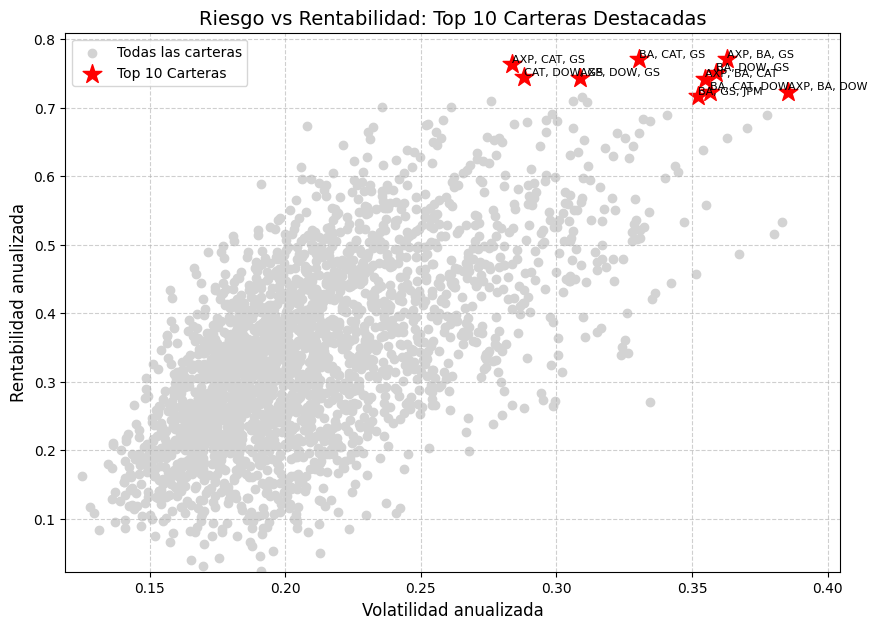

In [6]:
import matplotlib.pyplot as plt

top10 = carteras.head(10)

plt.figure(figsize=(10,7))
plt.scatter(carteras['volatilidad_anualizada'], carteras['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c='red', marker='*', s=200, label='Top 10 Carteras')

for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')

plt.xlim(carteras['volatilidad_anualizada'].min() * 0.95, carteras['volatilidad_anualizada'].max() * 1.05)
plt.ylim(carteras['rentabilidad_anualizada'].min() * 0.95, carteras['rentabilidad_anualizada'].max() * 1.05)


plt.title('Riesgo vs Rentabilidad: Top 10 Carteras Destacadas', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


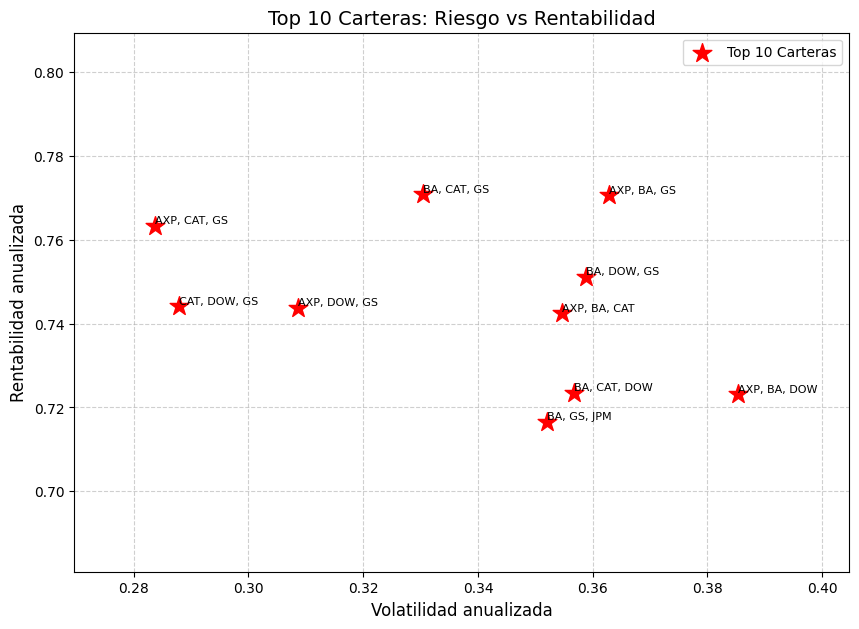

In [7]:
import matplotlib.pyplot as plt

top10 = carteras.head(10)

plt.figure(figsize=(10,7))
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c='red', marker='*', s=200, label='Top 10 Carteras')

for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')

plt.xlim(top10['volatilidad_anualizada'].min() * 0.95, top10['volatilidad_anualizada'].max() * 1.05)
plt.ylim(top10['rentabilidad_anualizada'].min() * 0.95, top10['rentabilidad_anualizada'].max() * 1.05)

plt.title('Top 10 Carteras: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


2º OPCIÓN: Métricas Sharpe

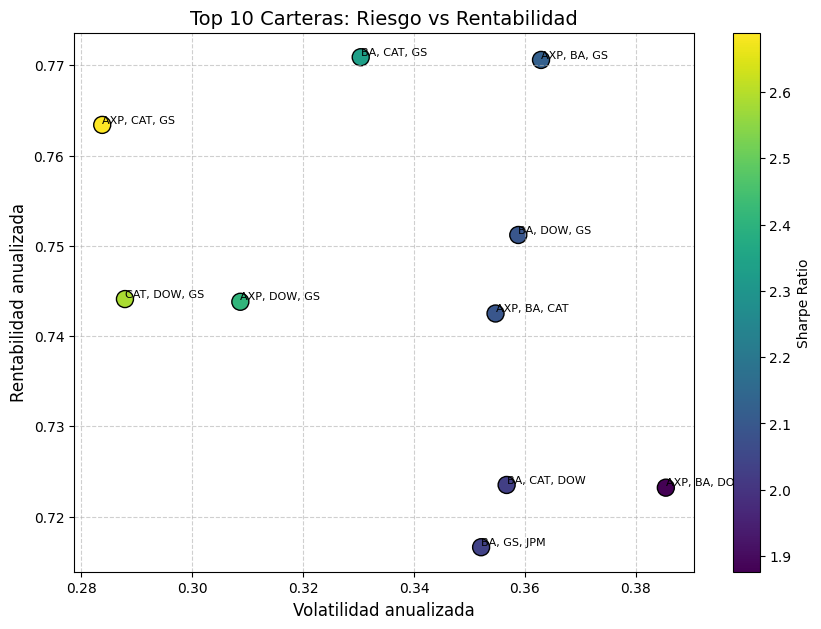

In [8]:
import matplotlib.pyplot as plt

top10 = carteras.head(10)

plt.figure(figsize=(10,7))
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c=top10['sharpe'], cmap='viridis', s=150, edgecolor='black')


for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')


plt.title('Top 10 Carteras: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.colorbar(label='Sharpe Ratio')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


3º OPCIÓN: Métricas Drawdown

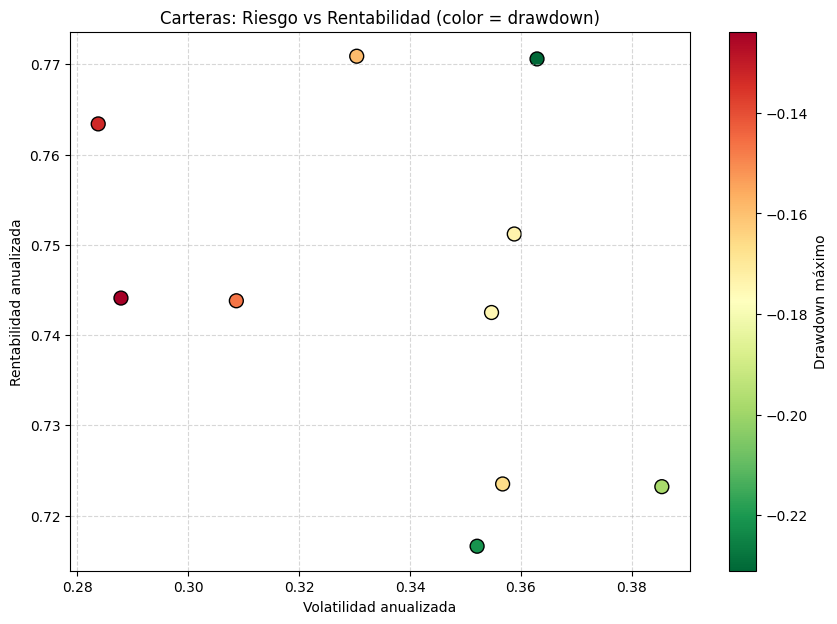

In [9]:
import matplotlib.pyplot as plt

top10 = carteras.head(10)
plt.figure(figsize=(10,7))

plt.scatter(
    top10['volatilidad_anualizada'],
    top10['rentabilidad_anualizada'],
    c=top10['drawdown_max'],  
    cmap='RdYlGn_r',             
    s=100,
    edgecolor='black'
)

plt.colorbar(label='Drawdown máximo')
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Carteras: Riesgo vs Rentabilidad (color = drawdown)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

4º OPCIÓN: Métricas

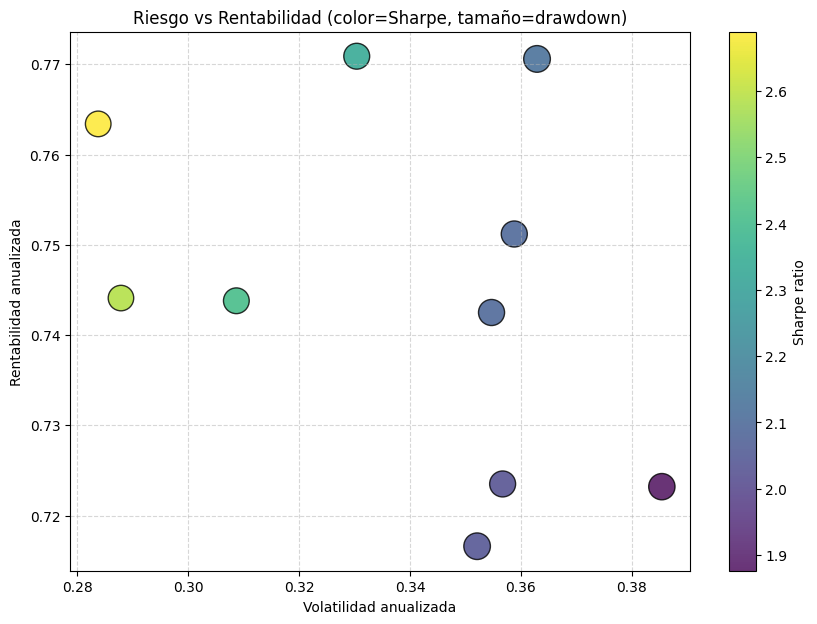

In [10]:
import matplotlib.pyplot as plt

top10 = carteras.head(10)
plt.figure(figsize=(10,7))

plt.scatter(
    top10['volatilidad_anualizada'],
    top10['rentabilidad_anualizada'],
    c=top10['sharpe'],              
    s=(1 - top10['drawdown_max']) * 300,  
    cmap='viridis',
    edgecolor='black',
    alpha=0.8
)

plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Riesgo vs Rentabilidad (color=Sharpe, tamaño=drawdown)')
plt.colorbar(label='Sharpe ratio')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


5º OPCIÓN: Correlación (seleccion_de_cartera.ipynb)

In [11]:
cols_numericas = df_ajustado.select_dtypes(include=[np.number]).columns
df_pct = df_ajustado[cols_numericas].pct_change()

In [12]:
# Calcula la matriz de correlaciones
corr_matrix = df_pct.corr()

# Encuentra los pares con menor correlación absoluta (excluyendo la diagonal)
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)

# Suma de correlaciones por activo (cuanto menor, más diversificado)
diversificacion = corr_abs.sum().sort_values()

# Selecciona los tres activos con menor suma de correlaciones
activos_diversificados = diversificacion.head(3).index.tolist()
print("Activos recomendados para diversificar:", activos_diversificados)

Activos recomendados para diversificar: ['CRM', 'AMGN', 'MSFT']


6º OPCIÓN: Combinación de métricas + correlación

In [13]:
import numpy as np
import pandas as pd

df_pct = df_ajustado.pct_change().dropna()

corr_matrix = df_pct.corr()

corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)

diversificacion = corr_abs.sum().sort_values()

n_activos_diversificados = 18
activos_diversificados = diversificacion.head(n_activos_diversificados).index.tolist()

print("Activos más diversificados:", activos_diversificados)


Activos más diversificados: ['CRM', 'AMGN', 'INTC', 'MSFT', 'MRK', 'NKE', 'PG', 'HD', 'UNH', 'JNJ', 'DIS', 'MMM', 'IBM', 'MCD', 'CSCO', 'CAT', 'TRV', 'BA']


In [14]:
import itertools

combinaciones = list(itertools.combinations(activos_diversificados, 3))
print(f"Se evaluarán {len(combinaciones)} combinaciones de 3 activos.")


Se evaluarán 816 combinaciones de 3 activos.


In [15]:
df_filtrado = df_ajustado[activos_diversificados]

carteras_filtradas = generar_carteras(df_filtrado)

top10 = carteras_filtradas.sort_values(by='sharpe', ascending=False).head(10)
top10


,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max
8,"(MSFT, NKE, CAT)",0.5882,0.1911,0.6299,3.0785,-0.0748
55,"(MSFT, HD, CAT)",0.4893,0.1715,0.5246,2.8534,-0.0791
46,"(MSFT, UNH, CAT)",0.4975,0.1770,0.5322,2.8113,-0.0841
73,"(MSFT, MCD, CAT)",0.4663,0.1665,0.5001,2.8002,-0.0752
15,"(MSFT, DIS, CAT)",0.5646,0.2040,0.5989,2.7685,-0.0846
116,"(MSFT, PG, CAT)",0.4336,0.1577,0.4656,2.7491,-0.0701
61,"(MSFT, MMM, CAT)",0.4811,0.1773,0.5137,2.7135,-0.0781
35,"(NKE, HD, CAT)",0.5148,0.1900,0.5476,2.7099,-0.1032
11,"(CRM, NKE, CAT)",0.5800,0.2144,0.6126,2.7051,-0.0778
28,"(MSFT, CAT, TRV)",0.5261,0.1946,0.5588,2.7032,-0.0834


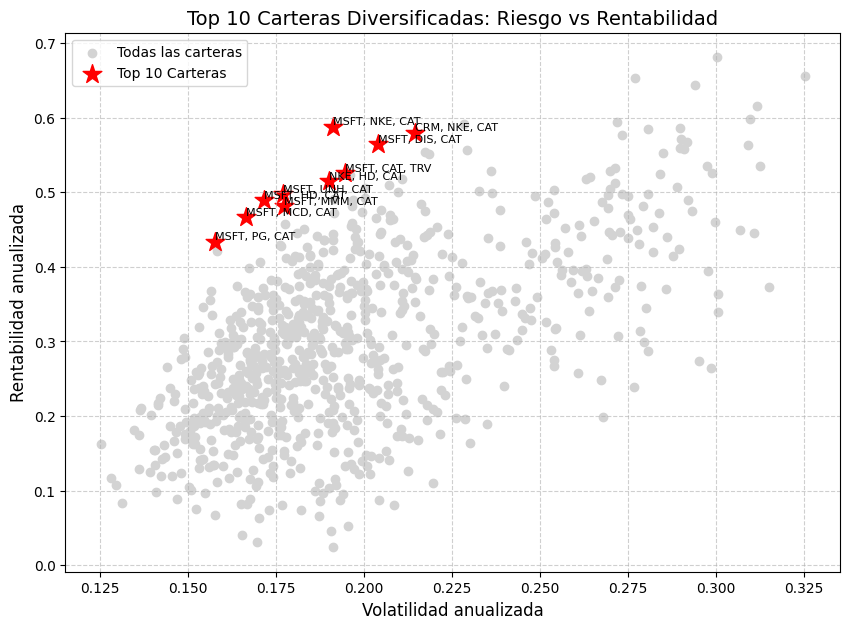

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(carteras_filtradas['volatilidad_anualizada'], carteras_filtradas['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top10['volatilidad_anualizada'], top10['rentabilidad_anualizada'], 
            c='red', marker='*', s=200, label='Top 10 Carteras')

for i, row in top10.iterrows():
    activos = ', '.join(row['cartera'])
    plt.text(row['volatilidad_anualizada'], row['rentabilidad_anualizada'], activos, fontsize=8, ha='left', va='bottom')

plt.title('Top 10 Carteras Diversificadas: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
